In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [15]:
df = pd.read_csv("data/dataset_SCL.csv")

/home/enrique/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [35]:
#We transform the date column to datetime and set the day to 01
flight_dates = pd.to_datetime(df["Fecha-I"], format='%Y-%m-%d').dt.date
flight_dates_01 = flight_dates.apply(lambda dt: dt.replace(day=1))

Text(0, 0.5, 'Frequency')

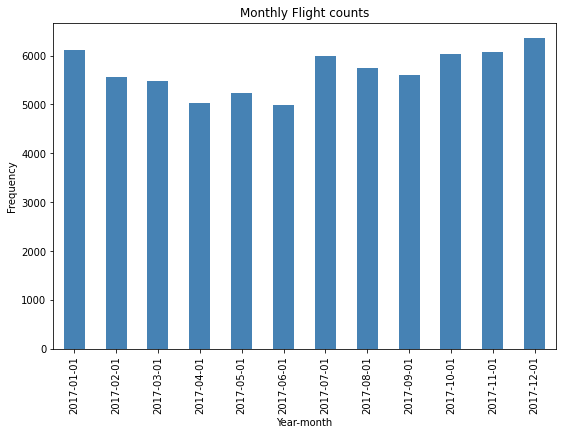

In [36]:
counts = flight_dates_01.value_counts().sort_index()
fig = plt.figure(figsize=(9, 6))
ax = fig.gca()
counts.plot.bar(ax = ax, color='steelblue')
ax.set_title('Monthly Flight counts')
ax.set_xlabel('Year-month')
ax.set_ylabel("Frequency")

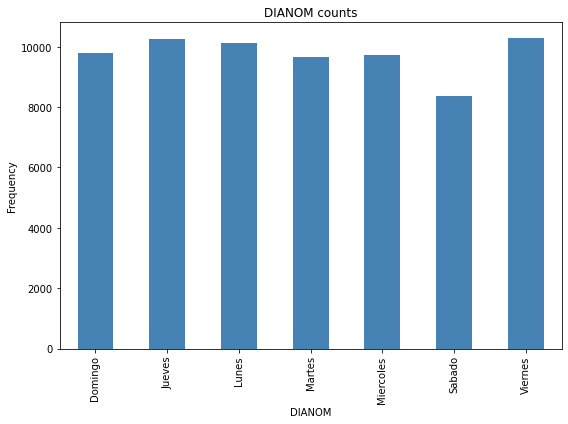

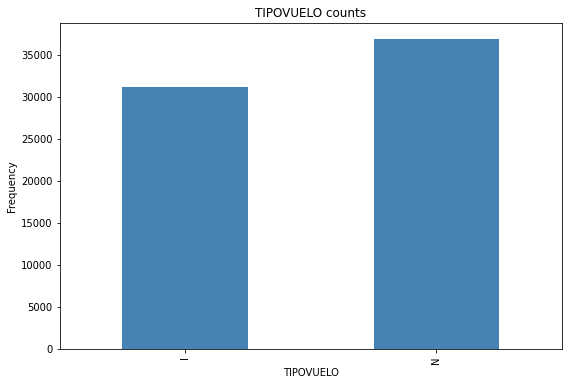

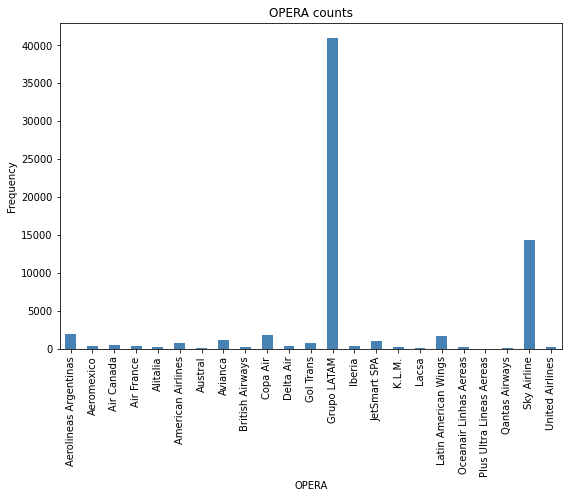

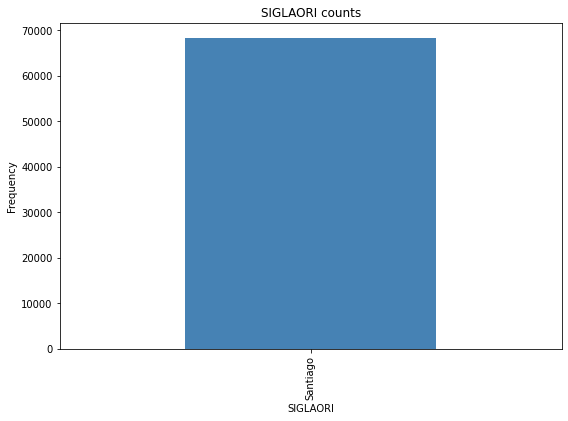

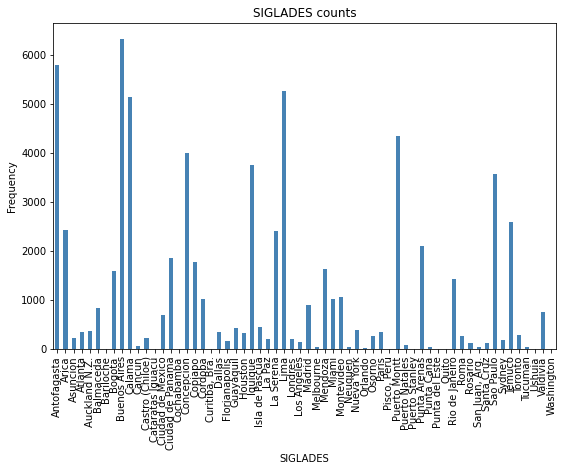

In [37]:
# plot a bar plot for each categorical feature count
categorical_features = ['DIANOM','TIPOVUELO','OPERA','SIGLAORI','SIGLADES']

for col in categorical_features:
    counts = df[col].value_counts().sort_index()
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    counts.plot.bar(ax = ax, color='steelblue')
    ax.set_title(col + ' counts')
    ax.set_xlabel(col) 
    ax.set_ylabel("Frequency")
plt.show()


In [57]:
temp_alta_1 = np.logical_or(flight_dates>=pd.datetime(2017,12,15).date(), flight_dates <=pd.datetime(2017,3,3).date())
temp_alta_2 = np.logical_and(pd.datetime(2017,7,1).date()<=flight_dates, flight_dates<=datetime(2017,7,31).date())
temp_alta_3 = np.logical_and(pd.datetime(2017,9,11).date()<=flight_dates, flight_dates<=pd.datetime(2017,9,30).date())
temp_alta = temp_alta_1 | temp_alta_2 |temp_alta_3

/tmp/ipykernel_22942/260999659.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  temp_alta_1 = np.logical_or(flight_dates>=pd.datetime(2017,12,15).date(), flight_dates <=pd.datetime(2017,3,3).date())
/tmp/ipykernel_22942/260999659.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  temp_alta_2 = np.logical_and(pd.datetime(2017,7,1).date()<=flight_dates, flight_dates<=datetime(2017,7,31).date())
/tmp/ipykernel_22942/260999659.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  temp_alta_3 = np.logical_and(pd.datetime(2017,9,11).date()<=flight_dates, flight_dates<=pd.datetime(2017,9,30).date())


In [72]:
fecha_I_datetime = pd.to_datetime(df["Fecha-I"], format='%Y-%m-%d')
fecha_O_datetime = pd.to_datetime(df["Fecha-O"], format='%Y-%m-%d')
dif_min = (fecha_O_datetime-fecha_I_datetime).astype('timedelta64[m]')

In [73]:
atraso_15 = dif_min > 15

In [74]:
synthetic_features_df = pd.DataFrame({"temp_alta" : temp_alta.astype(int), "dif_min" : dif_min, "atraso_15": atraso_15.astype(int)}) 

In [77]:
fecha_I_hour = fecha_I_datetime.dt.hour

In [86]:
synthetic_features_df.loc[(fecha_I_hour>=5) & (fecha_I_hour<=11), 'periodo_dia'] = 'mañana' 
synthetic_features_df.loc[(fecha_I_hour>=12) & (fecha_I_hour<=18), 'periodo_dia'] = 'tarde' 
synthetic_features_df.loc[(fecha_I_hour>=19) | (fecha_I_hour<=4), 'periodo_dia'] = 'noche' 

In [87]:
synthetic_features_df.head()

,temp_alta,dif_min,atraso_15,periodo_dia
0,1,3.0,0,noche
1,1,9.0,0,noche
2,1,9.0,0,noche
3,1,3.0,0,noche
4,1,-2.0,0,noche


In [88]:
synthetic_features_df.to_csv("data/synthetic_features.csv")

In [89]:
df_final = pd.concat([df, synthetic_features_df])

In [90]:
df_final

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,temp_alta,dif_min,atraso_15,periodo_dia
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,2017.0,Domingo,I,American Airlines,Santiago,Miami,NaN,NaN,NaN,NaN
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,2017.0,Lunes,I,American Airlines,Santiago,Miami,NaN,NaN,NaN,NaN
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,2017.0,Martes,I,American Airlines,Santiago,Miami,NaN,NaN,NaN,NaN
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,2017.0,Miercoles,I,American Airlines,Santiago,Miami,NaN,NaN,NaN,NaN
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,2017.0,Jueves,I,American Airlines,Santiago,Miami,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,46.0,1.0,tarde
68202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,16.0,1.0,tarde
68203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,40.0,1.0,tarde
68204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,13.0,0.0,tarde
